# Importação das Bibliotecas

In [2]:
import numpy as np              #lib cienfífica do python
import math                     #para ter-mos acesso a recursosd e calculos matemáticos
import re                       #porque vamos trabalhar com expressões regulares
import pandas as pd             #para carregar a base de dados
from bs4 import BeautifulSoup   #é usada pra se fazer preprocessamento em textos
from google.colab import drive  #para termos acesso de recursos do google drive
import zipfile                  #para poder descompactar arquivos .zip
import seaborn as sns           #para visualização de gráficos
import spacy as sp              #é uma lib de processamento de linguagem natural que será usada para fazer o preprocessamento em alguns textos
import string                   #vai ser usada para o pré processamento dos textos
import random                   #para números aleatórios
import matplotlib.pyplot as plt #usada para gerar gráficos
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow.keras import layers   #para ter-mos acesso as camadas
import tensorflow_datasets as tfds   

# Pré-Processamento

In [3]:
drive.mount("/content/drive")

Mounted at /content/drive


In [5]:
cols = ['sentiment', 'id', 'date', 'query', 'user', 'text']

In [6]:
dataset = pd.read_csv('/content/drive/MyDrive/Database/tweets.csv', header= None, names= cols, engine='python', encoding='latin1')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


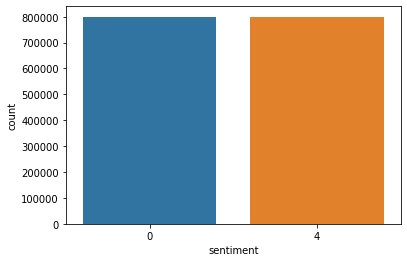

In [8]:
sns.countplot(dataset.sentiment)

In [11]:
dataset.head()

,sentiment,id,date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [12]:
dataset.drop(['id', 'date', 'query', 'user'], axis=1, inplace=True);

In [14]:
dataset.head()

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [15]:
y = dataset.iloc[:, 0]
X = dataset.iloc[:, 1]
[X.shape, y.shape]

[(1600000,), (1600000,)]

In [16]:
X, _, y, _ = train_test_split(X, y, test_size = 0.85, stratify = y) #reduzindo os dados que serão usados 

In [17]:
[X.shape, y.shape]

[(240000,), (240000,)]

In [21]:
sentimento, quantidade = np.unique(y, return_counts=True)
[sentimento, quantidade]

[array([0, 1]), array([120000, 120000])]

In [22]:
y[y == 4] = 1

In [23]:
sentimento, quantidade = np.unique(y, return_counts=True)
[sentimento, quantidade]

[array([0, 1]), array([120000, 120000])]

In [24]:
nlp = sp.load('en')
stop_words = sp.lang.en.STOP_WORDS #lista das palavras que podem ser removidas


In [27]:
def clean_tweets(tweet):
  tweet = BeautifulSoup(tweet, 'lxml').get_text()
  tweet = re.sub(r"@[A-Za-z0-9]+", ' ', tweet) #retirar o @user
  tweet = re.sub(r"https?://[A-Za-z0-9./]+", " ", tweet) #retirar a url
  tweet = re.sub(r"[^a-zA-Z.!?]", ' ', tweet) #retirar os numeros
  tweet = re.sub(r" +", ' ', tweet) #remover os excessos de espaços

  tweet = tweet.lower() #conversão para minúsculo
  document = nlp(tweet)

  words = []
  for token in document:
    words.append(token.text)

    #remoção das stop_words e pontuações
  words = [word for word in words if word not in stop_words and word not in string.punctuation]
  words = ' '.join([str(element) for element in words])
  return words

In [32]:
text = '@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds'

In [33]:
text = clean_tweets(text)
text

'  dived times ball managed save rest bounds'

In [34]:
data_clean = [clean_tweets(tweet) for tweet in X]

In [35]:
for _ in range(10):
  print(data_clean[random.randint(0, len(data_clean) - 1)])

  sweet drunkie
krill unique discovery decade bet wrong
start twittering
realized forgot tell tv record gossip girl super pissed ed westwick
  check cattle prods today
super paranoid right s mosquito room
half way work today bummer
momma s finally taking shopping s time mommy time
  s exciting congrats hour mins cardio
  thank ... lovely catch


# Tokenização

In [37]:
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(data_clean, target_vocab_size=65000)

*   A língua inglesa tem um total estimado de palavras entre 500 mil e 1,2 milhão.
*   Uma pessoa adulta pode conhecer entre 10 mil e 20 mil palavras
*   No dia a dia as pessoas costumam usar em média 3 mil palavras

Ou seja,
> Não precisa de um vocabulário gigantemente enorme para o algoritmo funcionar








In [39]:
print(tokenizer.vocab_size)

52657


In [42]:
id_phrase = tokenizer.encode("i am happy")
id_phrase

[274, 4371, 418]

In [44]:
phrase = tokenizer.decode(id_phrase)
phrase

'i am happy'

In [46]:
data_inputs = [tokenizer.encode(frase) for frase in data_clean]

In [48]:
for _ in range(10):
  print(data_inputs[random.randint(0, len(data_inputs) - 1)])

[3831, 28291, 597]
[1, 1745, 470, 4, 214, 5006]
[776]
[2147]
[1, 20, 16816, 5603, 11104, 47, 1723, 39895, 3709, 111, 21824, 5284]
[45, 43, 357, 6438, 5, 6851, 52522]
[388, 9633, 3, 4066]
[1, 48, 138, 889, 4925, 1396, 2, 1482, 4797, 7605, 1270, 16813, 5920, 4015]
[1, 339, 11994, 250, 6328, 4, 64, 76, 28430, 1243]
[202, 26, 217, 3, 2725, 108, 34, 119, 769, 16]


# Padding

In [50]:
max_len = max([len(sentence) for sentence in data_inputs]) #vendo quem tem o maior tamanho
max_len

46

In [51]:
#fazer o preenchimento para todos os data_inputs possuírem o mesmo tamanho
data_inputs = tf.keras.preprocessing.sequence.pad_sequences(data_inputs, value=0, padding='post', maxlen=max_len)

In [52]:
for _ in range(10):
  print(data_inputs[random.randint(0, len(data_inputs) - 1)])

[    1    14   240   360    20 24358 17545     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0]
[  11 2806    2  134 6125 1110  633 2805 3845  968  258 1097   35  127
   31  699    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0]
[  1  92 119 783 461   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0]
[  1   6  42 824 268 802  17  44   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0]
[32072 48770 52433  3968   464     2   203 47968  2603    29   191   162
 13297    30 40085    35   697     

# Divisão dos Dados em Treino e Teste

In [104]:
train_X, test_X, train_y, test_y = train_test_split(data_inputs, y, test_size=0.3, stratify = y)
#30% para teste e 70% para treinamento

In [56]:
[train_X.shape, train_y.shape]

[(168000, 46), (168000,)]

In [57]:
[test_X.shape, test_y.shape]

[(72000, 46), (72000,)]

# Construção do Modelo

In [58]:
class DCNN (tf.keras.Model):
  def __init__(self, vocab_size, emb_dim, nb_filters, ffn_units, nb_classes, dropout_rate, training=False, name="dcnn"):
    super(DCNN, self).__init__(name=name)

    #primeira camada é de embeding
    self.embedding = layers.Embedding(vocab_size, emb_dim)
    #gerar uma matriz com a quantidade de linhas que o vocabulário tem e 128 colunas
    #primeira camada pronta

    self.bigram = layers.Conv1D(filters=nb_filters, kernel_size=2, padding='same', activation='relu') #objeto (filtro com 2 linhas)

    self.trigram = layers.Conv1D(filters=nb_filters, kernel_size=3, padding='same', activation='relu') #objeto (filtro com 3 linhas)

    self.fourgram = layers.Conv1D(filters=nb_filters, kernel_size=4, padding='same', activation='relu') #objeto (filtro com 4 linhas)
    #camadas de convolução prontas

    #definir uma camada para fazer o pooling
    self.pool =  layers.GlobalMaxPool1D()
    #porque só vamos usar uma camada de pooling que vai extrair informação de todos os filtros feitos e no fim será feita a concatenação

    #definir agora a estrutura da rede neural densa
    self.dense_1 = layers.Dense(units = ffn_units, activation = 'relu')  #a primeira camada oculta terá 512 neurônios 
    self.dropout = layers.Dropout(rate = dropout_rate) #ele vai zerar 10% dos valores da camada oculta para evitar overfiting

    #camada de saída
    self.last_dense = layers.Dense(units = 1, activation = 'sigmoid')
    
  #interligar as camadas
  def call(self, inputs, training):
    x = self.embedding(inputs) #passando os textos para a camada de embeding
    x_1 = self.bigram(x) #ligando o X com a camda bigram 
    x_1 = self.pool(x_1) #ligando o x_1 com a camada de pooling
    x_2 = self.trigram(x) #ligando X com a camada trigram 
    x_2 = self.pool(x_2) #ligando x_2 com a camada de pooling
    x_3 = self.fourgram(x) #ligando x com o fourgram
    x_3 = self.pool(x_3) #ligando x_4 com a camada de pooling

    merged = tf.concat([x_1, x_2, x_3], axis = -1) # (batch_size, 3 * nb_filters)
    merged = self.dense_1(merged) #ligando os dados que saem das camadas acima com a primeira camada densa
    merged = self.dropout(merged, training)
    output = self.last_dense(merged)

    return output


## Treinamento

In [67]:
vocab_size = tokenizer.vocab_size
emb_dim = 200
nb_filters = 100 #trabalhar com 100 filtros (300 filtros)
ffn_units = 256 #quantidade de neurônios na camada oculta
batch_size = 64 #fazer o ajuste dos pesos em 64 e 64 registros
nb_classes = 2 #quantidade de classes
dropout_rate = 0.2 
nb_epochs = 3

In [68]:
Dcnn = DCNN(vocab_size=vocab_size, emb_dim=emb_dim, nb_filters=nb_filters, ffn_units=ffn_units, nb_classes=nb_classes, dropout_rate=dropout_rate)

In [69]:
Dcnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [71]:
#treinamento
history = Dcnn.fit(train_X, train_y, batch_size = batch_size, epochs = nb_epochs, verbose = 1, validation_split = 0.10)

Epoch 1/3
2363/2363 [==============================] - 467s 198ms/step - loss: 0.1002 - accuracy: 0.9585 - val_loss: 1.0947 - val_accuracy: 0.7412
Epoch 2/3
2363/2363 [==============================] - 463s 196ms/step - loss: 0.0690 - accuracy: 0.9709 - val_loss: 1.2494 - val_accuracy: 0.7344
Epoch 3/3
2363/2363 [==============================] - 463s 196ms/step - loss: 0.0544 - accuracy: 0.9772 - val_loss: 1.4256 - val_accuracy: 0.7274


# Validação do Modelo

In [73]:
results = Dcnn.evaluate(test_X, test_y, batch_size=batch_size)
_, acuracia = results
print(acuracia)

1125/1125 [==============================] - 31s 27ms/step - loss: 1.4174 - accuracy: 0.7263
0.7263055443763733


In [88]:
y_preditor_test = Dcnn.predict(test_X)

In [91]:
y_preditor_test.

array([[0.9839145 ],
       [0.5520377 ],
       [0.02375257],
       ...,
       [0.40544277],
       [0.99978316],
       [0.99985576]], dtype=float32)

In [82]:
y_preditor_test

numpy.ndarray

In [97]:
saida_treinamento = (y_preditor_test > 0.5)
saida_treinamento

array([[ True],
       [ True],
       [False],
       ...,
       [False],
       [ True],
       [ True]])

In [107]:
test_y

1215068    1
645086     0
1534428    1
251667     0
549557     0
          ..
623781     0
493712     0
806335     1
439670     0
1266672    1
Name: sentiment, Length: 72000, dtype: int64

In [110]:
cm = confusion_matrix(test_y, saida_treinamento)
cm
#reg da classe 0 classificado como 0 | reg da classe 0 classificado como 1
#reg da classe 1 classificado como 1 | reg da classe 1 classificado como 1

array([[16789, 19211],
       [16871, 19129]])

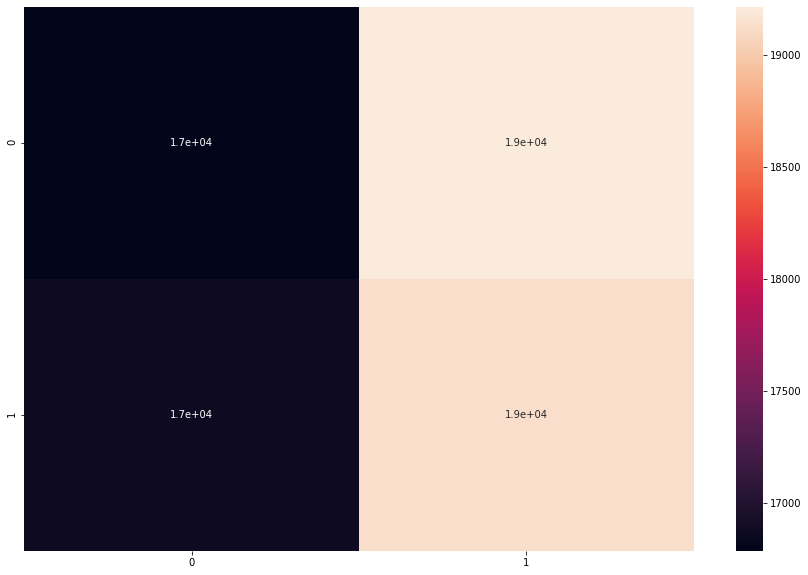

In [112]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(cm, annot=True)

#linha vestical: classe
#linha horizontal: como foi classificado

#classe 0 classificado como 0, classe 0 classificado como 1
#classe 1 classificado como 0, classe 1 classificado como 1

In [139]:
text = 'i love you'
text = tokenizer.encode(text)
prob = Dcnn(np.array([text]), training=False).numpy()

if prob > 0.5:
  print("sentimento positivo. saida:", prob)
else:
  print("sentimento negativo. saida:", prob)

sentimento positivo. saida: [[0.9999982]]
